In [ ]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#importing database
xls = "Données  - Risque.xlsx"
df = pd.read_excel(xls, sheet_name="Data")

In [ ]:
df.head()

,NODE,dateEST,DAM_LMP,LOAD FORECAST,OUTAGE FORECAST
0,NSP.FRENCH1,2009-01-01 01:00:00,25.36,59910,7460.0
1,NSP.FRENCH1,2009-01-01 02:00:00,24.07,58360,7980.0
2,NSP.FRENCH1,2009-01-01 03:00:00,22.50,57780,7980.0
3,NSP.FRENCH1,2009-01-01 04:00:00,21.71,56990,7980.0
4,NSP.FRENCH1,2009-01-01 05:00:00,21.39,56730,7980.0


In [ ]:
#rows & columns of the dataset
df.shape

(43210, 5)

In [ ]:
#unicity check
df.NODE.unique()

array(['NSP.FRENCH1'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43210 entries, 0 to 43209
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   NODE             43210 non-null  object        
 1   dateEST          43210 non-null  datetime64[ns]
 2   DAM_LMP          43210 non-null  float64       
 3   LOAD FORECAST    43210 non-null  int64         
 4   OUTAGE FORECAST  43210 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.6+ MB


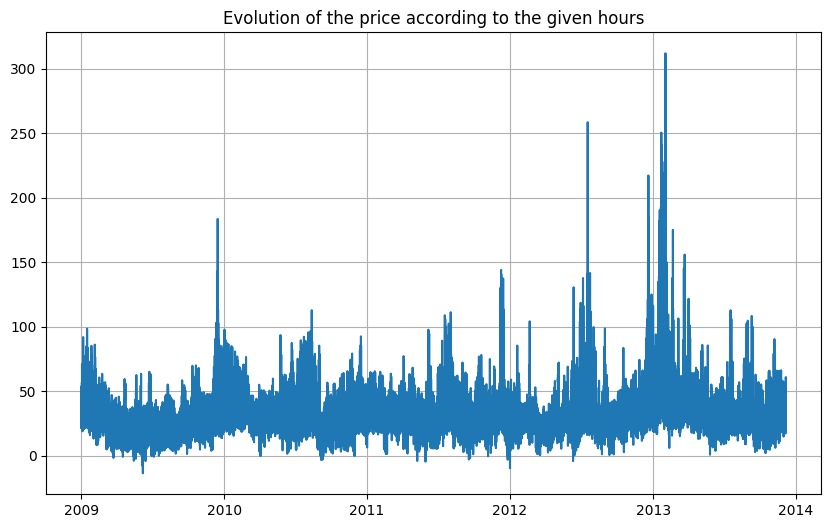

In [ ]:
#Evolution of the price according to the given hours
plt.figure(figsize=(10, 6))
plt.plot(df['dateEST'], df['DAM_LMP'])
plt.grid('True')
plt.title('Evolution of the price according to the given hours')
plt.show()


In [ ]:
## Auto-Regressive Modelling approach

In [ ]:
prep_df = df.set_index('dateEST')

In [ ]:
prep_df['DAM_LMP'].resample('D').mean()

dateEST
2009-01-01    30.372174
2009-01-02    40.095833
2009-01-03    28.730000
2009-01-04    32.045417
2009-01-05    49.201250
                ...    
2013-12-02    30.485833
2013-12-03    30.757083
2013-12-04    28.028750
2013-12-05    32.018333
2013-12-06    30.580000
Freq: D, Name: DAM_LMP, Length: 1801, dtype: float64

In [ ]:
#stationarity test (no stationarity = cycles, seasons)
from statsmodels.tsa.stattools import adfuller
def ADF(serie):
    result = adfuller(serie)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
ADF(prep_df['DAM_LMP'])
#Stationary time series (p value <0.05)

ADF Statistic: -14.013843
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


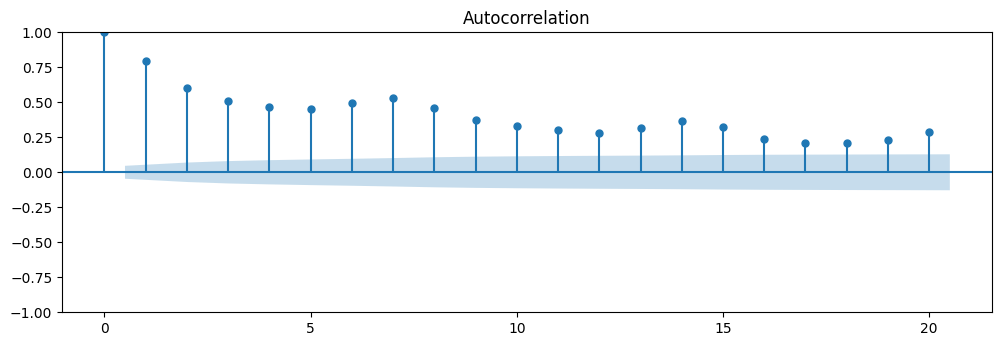

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(prep_df['DAM_LMP'].resample('D').mean(), lags=20, ax=ax1)

In [ ]:
#there are missing dates(hours), let's look for all dates between the first and the last date of the database
min_time = prep_df.index.min()
max_time = prep_df.index.max()
complete_time_range = pd.date_range(start=min_time, end=max_time, freq='H')
complete_time_range

DatetimeIndex(['2009-01-01 01:00:00', '2009-01-01 02:00:00',
               '2009-01-01 03:00:00', '2009-01-01 04:00:00',
               '2009-01-01 05:00:00', '2009-01-01 06:00:00',
               '2009-01-01 07:00:00', '2009-01-01 08:00:00',
               '2009-01-01 09:00:00', '2009-01-01 10:00:00',
               ...
               '2013-12-05 15:00:00', '2013-12-05 16:00:00',
               '2013-12-05 17:00:00', '2013-12-05 18:00:00',
               '2013-12-05 19:00:00', '2013-12-05 20:00:00',
               '2013-12-05 21:00:00', '2013-12-05 22:00:00',
               '2013-12-05 23:00:00', '2013-12-06 00:00:00'],
              dtype='datetime64[ns]', length=43200, freq='H')

In [ ]:
prep_df.reset_index(inplace=True)

In [ ]:
#if we merge two databases it will create a new database whith NULL value for the corresponding dates, this NULLS
#we gonne fill them after
complete_df = pd.DataFrame({'dateEST': complete_time_range})
merged_df = pd.merge(complete_df, prep_df, on='dateEST', how='left')

In [ ]:
#we fil the NULLS with the previous price
merged_df = merged_df.set_index('dateEST').ffill()

In [ ]:
#in the data base there duplicated rows, so i chose to keep always the first one
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

In [ ]:
merged_df.corr()

<ipython-input-18-5805580b1846>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_df.corr()


,DAM_LMP,LOAD FORECAST,OUTAGE FORECAST
DAM_LMP,1.000000,0.615934,-0.090323
LOAD FORECAST,0.615934,1.000000,-0.395691
OUTAGE FORECAST,-0.090323,-0.395691,1.000000


In [ ]:
# training_df = merged_df.iloc[:-24]
# last_day = merged_df.iloc[-24:]

In [ ]:
# prep_df.iloc[:-24]

In [ ]:
# prep_df.iloc[-24:]

In [ ]:
merged_df = merged_df[["DAM_LMP", "LOAD FORECAST", "OUTAGE FORECAST"]]

In [ ]:
merged_df.describe()
#negative values for the price ?

,DAM_LMP,LOAD FORECAST,OUTAGE FORECAST
count,43200.000000,43200.000000,43200.000000
mean,31.604514,62007.486366,16304.128657
std,17.148298,10878.352126,6825.400848
min,-13.660000,38654.000000,4060.000000
25%,21.060000,54140.000000,10840.000000
50%,28.675000,60753.500000,15440.000000
75%,38.630000,68031.750000,21409.400000
max,312.000000,110870.000000,66226.000000


In [ ]:
def make_training_data(vect, features):
    X_train = []
    y_train = []

    for t in range(len(vect) - features):
        X_train.append(vect[t:t+features])
        y_train.append(vect[t+features])
    X_train = np.array(X_train).reshape(-1, features)
    y_train = np.array(y_train)
    return X_train, y_train

In [ ]:
X_train, y_train = make_training_data(merged_df['DAM_LMP'], 24)

In [ ]:
X_price_ind1, _ = make_training_data(merged_df['LOAD FORECAST'], 24)
X_price_ind2, _ = make_training_data(merged_df['OUTAGE FORECAST'], 24)

In [ ]:
#hstack to concat to arrays
X_train_add = np.hstack([X_train, X_price_ind1, X_price_ind2])

In [ ]:
# we chose one year as test
training_df = X_train_add[:-24 * 365]
testing_df = X_train_add[-24 * 365:]

In [ ]:
train_y = y_train[:-24 * 365]
test_y = y_train[-24 * 365:]

In [ ]:
(train_y.shape, test_y.shape)

((34416,), (8760,))

In [ ]:
training_df.shape, testing_df.shape

((34416, 72), (8760, 72))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
model = LinearRegression()
model.fit(training_df, train_y)
model.score(training_df, train_y)

0.9353840258280113

In [ ]:
preds = model.predict(testing_df)
r2_score(preds, test_y)

0.865622992336997

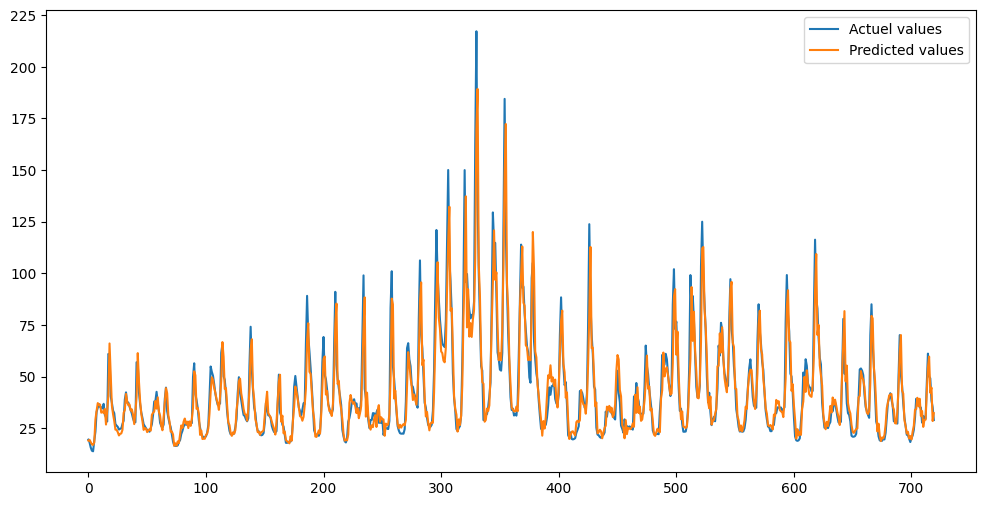

In [ ]:
#Since we have a low frequency, we have chosen to plot this figure for only one month
#to clearly observe how the predictions align with the actual values.
plt.figure(figsize=(12, 6))
plt.plot(test_y[:24*30], label = 'Actuel values')
plt.plot(preds[:24*30], label = 'Predicted values')
plt.legend()
plt.show()